In [ ]:
# load the model from checkpoint
from models.xLSTM import myxLSTM
import torch

#without gradient loss
# path = 'lightning_logs/version_107/checkpoints/epoch=5-step=16176.ckpt'

#with gradient loss
# path = 'lightning_logs/version_108/checkpoints/epoch=3-step=10784.ckpt'
# path = 'lightning_logs/version_111/checkpoints/epoch=5-step=16176.ckpt'
# path = 'pretrain-xLSTM/xyq7f8n9/checkpoints/epoch=3-step=10784.ckpt'


# grad loss ps 128
path = 'pretrain-xLSTM/c4jfaten/checkpoints/epoch=8-step=20115.ckpt'

patch_size=128

class Args:
    def __init__(self):
        self.patch_size = patch_size
        self.dropout = 0.2
        self.embedding_size = 748
        self.num_heads = 4
        self.activation_fn = 'relu'
        self.xlstm_config = ['m', 's', 'm', 'm', 'm', 'm', 'm', 'm']
        self.multi_token_prediction = True
        self.use_tab_data = False
        self.activation_fn = 'gelu'
        self.loss_type = 'grad_min_max'


config = Args()

xlstm = myxLSTM(5, num_channels=12, config=config)
checkpoint = torch.load(path)
print(checkpoint.keys())
print(checkpoint['hyper_parameters'])
state_dict = checkpoint['state_dict']
# Remove 'model.' prefix from keys
new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
print(new_state_dict.keys())
xlstm.load_state_dict(new_state_dict, strict=True)
xlstm.eval()


{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda-12.6/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=748', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DS

Using /home/luna97/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/luna97/.cache/torch_extensions/py311_cu124/slstm_HS748BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS748BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS748BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/xlstm/blocks/slstm/cell

ninja: no work to do.
{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda-12.6/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=748', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=4', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-devic

Using /home/luna97/.cache/torch_extensions/py311_cu124 as PyTorch extensions root...
No modifications detected for re-loaded extension module slstm_HS748BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0, skipping build step...
Loading extension module slstm_HS748BS8NH4NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])
{'len_train_dataset': 1144192, 'config': Namespace(lr=0.0001, wd=0.1, batch_size=512, num_workers=32, epochs=100, patch_size=128, dropout=0.2, embedding_size=748, multi_token_prediction=True, loss_type='grad', deterministic=True, use_tab_data=False, patience=10, is_sweep=False, series_decomposition=0, grad_clip=5, optimizer='adamw', use_scheduler=True, num_epochs_warmup=2, num_epochs_warm_restart=5, sched_decay_factor=0.8, activation_fn='relu', xlstm_config=['m', 's', 'm', 'm', 'm', 'm', 'm', 'm'], wandb_log=True, patch_embedding='linear', num_heads=4, normalize=False, oversample=False, random_shift=True, pretrain_datasets=['mimic', 'code15'], nk_clean=True, leads=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6'], data_folder_mit='/media/Volume/data/MIT-BHI/data/', data_folder_code15='/med

/tmp/ipykernel_911365/3980471441.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


myxLSTM(
  (dropout): Dropout(p=0.2, inplace=False)
  (activation): GELU(approximate='none')
  (patch_embedding): PatchEmbedding(
    (conv): LazyConv1d(0, 748, kernel_size=(128,), stride=(128,))
  )
  (xlstm): xLSTMBlockStack(
    (blocks): ModuleList(
      (0-1): 2 x sLSTMBlock(
        (xlstm_norm): LayerNorm()
        (xlstm): sLSTMLayer(
          (conv1d): CausalConv1d(
            (conv): Conv1d(748, 748, kernel_size=(4,), stride=(1,), padding=(3,), groups=748)
          )
          (conv_act_fn): SiLU()
          (fgate): LinearHeadwiseExpand(in_features=748, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (igate): LinearHeadwiseExpand(in_features=748, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (zgate): LinearHeadwiseExpand(in_features=748, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (ogate): LinearHeadwiseExpan

In [9]:
# get one sample from the dataset
import numpy as np
from torch.utils.data import DataLoader
from torch.nn import functional as F

from dataset.mit_bih import ECGMITBIHDataset
from dataset.code_15 import ECGCODE15Dataset

class DatasetArgs:  
    def __init__(self):
        self.data_folder_code15 = '/media/Volume/data/CODE15/nkclean_360_12l'
        self.labels_file_code15 = '/media/Volume/data/CODE15/labels.csv'
        self.data_folder_mit = '/media/Volume/data/MIT-BHI/data/'
        self.use_tab_data = False
        self.patch_size = 128
        self.normalize = True
        self.random_shift = False
        self.oversample=False
        self.nk_clean=True
        self.leads = ['*']

dataset = ECGCODE15Dataset(DatasetArgs(), leads_to_use=['*'])

Finding records in /media/Volume/data/CODE15/nkclean_360_12l...


345780it [00:04, 82883.53it/s]


loaded 344699 records


In [10]:
dataset_mit = ECGMITBIHDataset(DatasetArgs(), use_labels_in_tab_data=False)

from utils.utils import get_training_class_weights
print(get_training_class_weights(dataset_mit).to('cuda'))

/home/luna97/Research/MIT-BIH_ecg_arrhytmia/dataset/mit_bih.py:35: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  self.samples = pd.read_csv(os.path.join(self.data_folder, name, f'labels_{subset}.csv'))


Class Counts: Counter({0: 45866, 2: 3788, 1: 944, 3: 415, 4: 8})
Class Weights: tensor([2.2248e-01, 1.0810e+01, 2.6938e+00, 2.4588e+01, 1.2755e+03])
tensor([2.2248e-01, 1.0810e+01, 2.6938e+00, 2.4588e+01, 1.2755e+03],
       device='cuda:0')


signal shape torch.Size([1, 2949, 12])


findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.


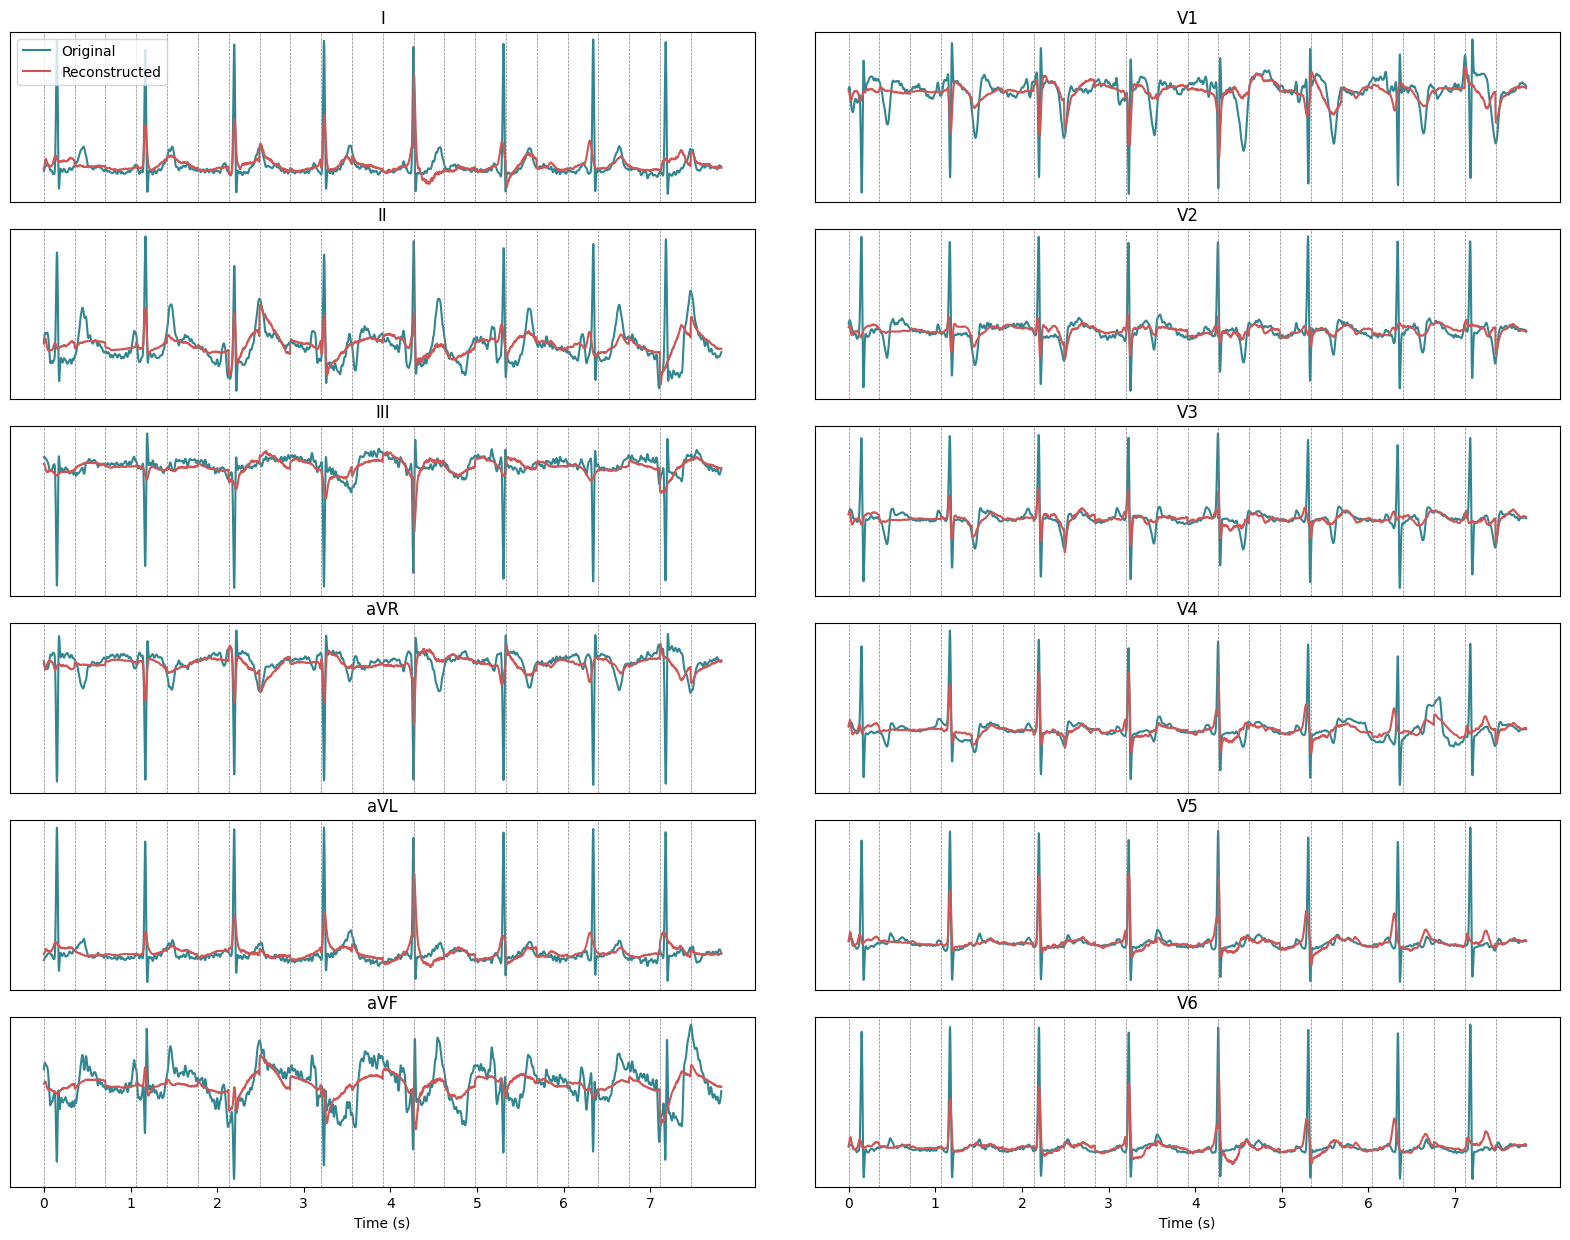

findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.
findfont: Font family 'Lato' not found.


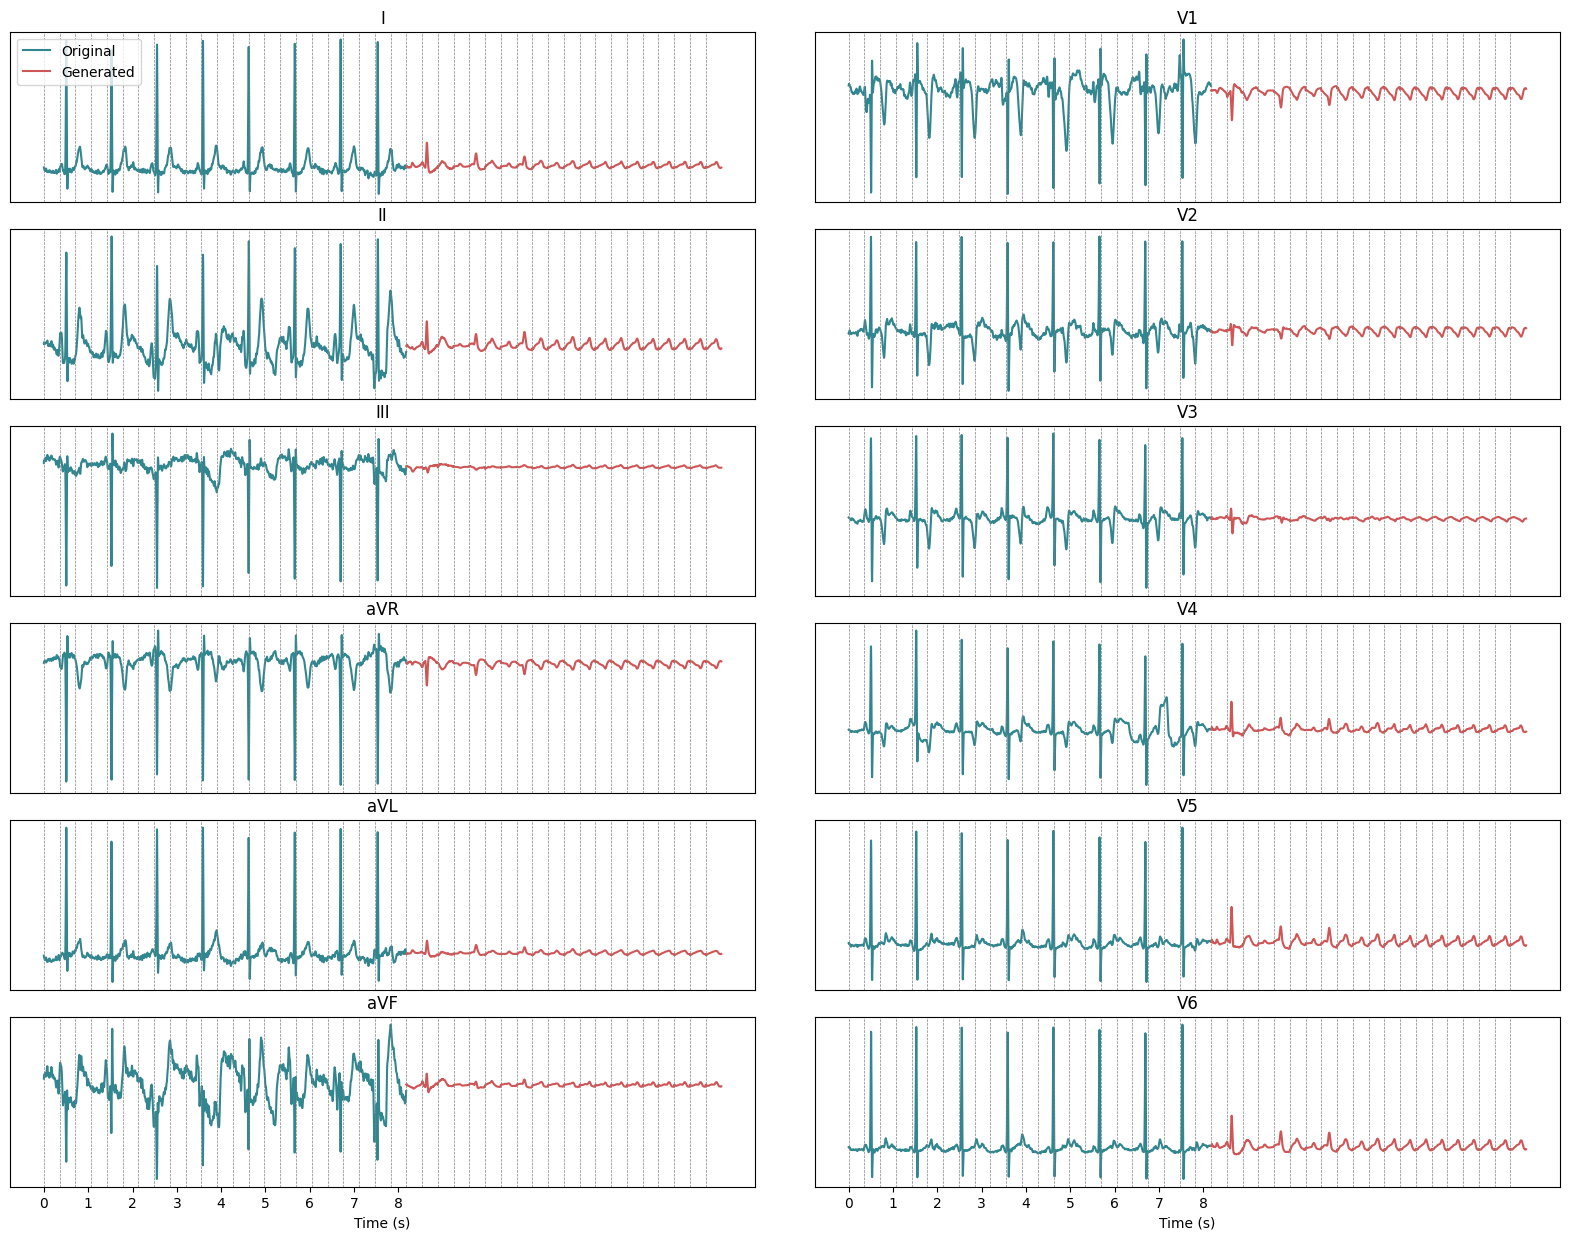

In [58]:
xlstm = xlstm.to('cuda')
xlstm.eval()
# idx with S: 420 # idx with v: 1967 # idx with F: 4362 # idx with Q: 360 # idx with N: 7544
# get test dataset
sample = dataset[7]
# tab_data = sample['tab_data']

def get_reconstruction(sample, model, patch_size):
    with torch.no_grad():
        tab_data = sample['tab_data'] if 'tab_data' in sample.keys() else None
        signal = sample['signal'].to('cuda').unsqueeze(0)
        if len(signal.shape) == 2:
                signal = signal.unsqueeze(-1)
        print('signal shape', signal.shape)

        # signal = F.pad(signal, (0, 0, 0, patch_size - signal.shape[1] % patch_size))

        reconstruct = model.reconstruct(signal, tab_data) # [batch_size, seq_len // 64, patch_size]
        if isinstance(reconstruct, tuple):
            reconstruct = reconstruct[0]

        shift_x = signal[:, :reconstruct.shape[1]]
        shift_x = shift_x[:, patch_size:].squeeze()

        shift_reconstruct = reconstruct[:, :-patch_size]
        return shift_x.view(1, -1, 12), shift_reconstruct.view(1, -1, 12)
    

def plot_generation(sample, model, patch_size, length=10):
    with torch.no_grad():
        tab_data = sample['tab_data'] if 'tab_data' in sample.keys() else None
        signal = sample['signal'].to('cuda').unsqueeze(0)

        # signal = F.pad(signal, (0, 0, 0, patch_size - signal.shape[1] % patch_size))


        # remove the part of signal outside % path_size
        signal = signal[:, :signal.shape[1] - signal.shape[1] % patch_size]
        #print(signal.shape[1])
        #print(patch_size)

        if len(signal.shape) == 2:
            signal = signal.unsqueeze(-1)

        # print('signal shape', signal.shape)

        generated = model.generate(signal, tab_data=tab_data, length=length)

        return signal, generated



idxs = [7, 11, 40, 111]

# for each index, plot the reconstruncton 

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


fig = plt.figure(figsize=(20, 15))
sample = dataset[234]

# rgb
color_1 = (50 / 255, 134 / 255, 143 / 255)
color_2 = (207/ 255, 86/ 255, 86/ 255)

leads = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
# plot all leads
shift_x, shift_reconstruct = get_reconstruction(sample, xlstm, patch_size)
x, generated_x = plot_generation(sample, xlstm, patch_size, length=20)

gs = gridspec.GridSpec(6, 2)
gs.update(wspace=0.08, hspace=0.16)

for i in range(12):
    ax = plt.subplot(gs[i % 6, i // 6])
    ax.plot(shift_x[..., i].cpu().squeeze().numpy(), color=color_1)
    ax.plot(shift_reconstruct[..., i].cpu().squeeze().numpy(), color=color_2)
    ax.set_title(leads[i],)

    # add vertical lines avery patch size
    for j in range(0, shift_x.shape[1], patch_size):
        ax.axvline(j, color='gray', linestyle='--', linewidth=0.5)

    ax.set_yticks([])
    if i == 0:
        ax.legend(['Original', 'Reconstructed'], loc='upper left')

    if i == 5 or i == 11:
        ax.set_xticks(np.arange(0, len(shift_x[0]), 360))
        ax.set_xticklabels(np.arange(0, len(shift_x[0]), 360) // 360)
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xticks([])

# new fig
fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(6, 2)
gs.update(wspace=0.08, hspace=0.16)

for i in range(12):
    ax = plt.subplot(gs[i % 6, i // 6])
    ax.plot(x[..., i].cpu().squeeze().numpy(), color=color_1)
    ax.plot(
        range(x.shape[1], x.shape[1] + generated_x.shape[1]),
        generated_x[..., i].cpu().squeeze().numpy(), color=color_2)
    ax.set_title(leads[i],)

    # add vertical lines avery patch size
    for j in range(0, x.shape[1] + generated_x.shape[1], patch_size):
        ax.axvline(j, color='gray', linestyle='--', linewidth=0.5)

    ax.set_yticks([])
    if i == 0:
        ax.legend(['Original', 'Generated'], loc='upper left')

    if i == 5 or i == 11:
        ax.set_xticks(np.arange(0, len(x[0]), 360))
        ax.set_xticklabels(np.arange(0, len(x[0]), 360) // 360)
        ax.set_xlabel('Time (s)')
    else:
        ax.set_xticks([])





In [60]:
np.random.rand(12)

array([0.89223585, 0.75251264, 0.81989669, 0.65700745, 0.91025397,
       0.55224419, 0.7053196 , 0.76258141, 0.63970759, 0.05016557,
       0.20528462, 0.59567022])

signal shape torch.Size([1, 2112, 1])
torch.Size([1, 1920])


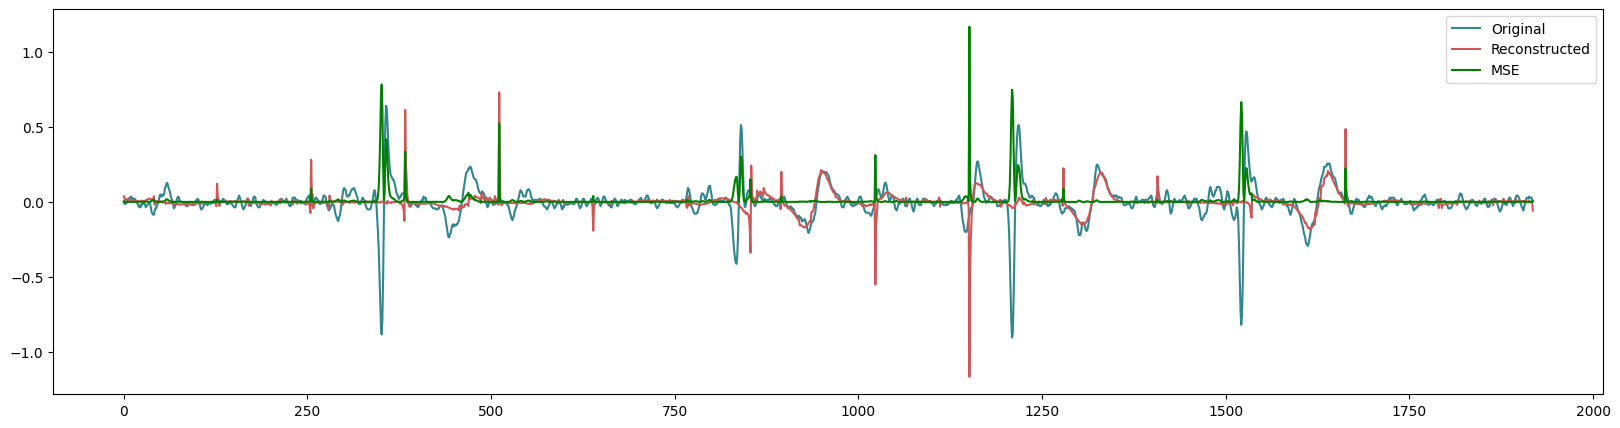

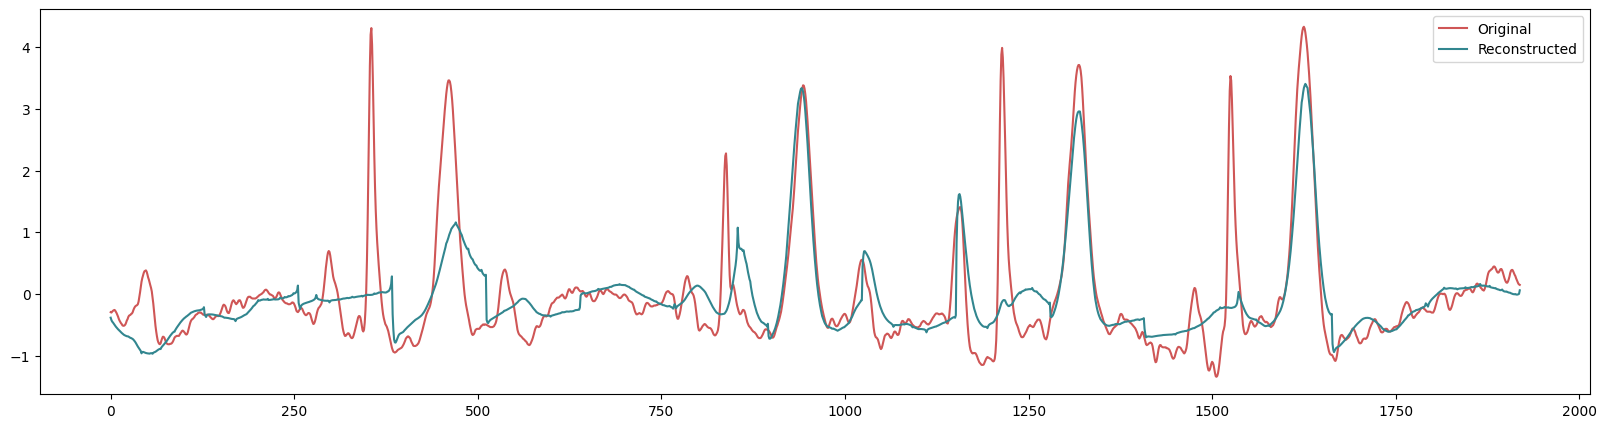

In [ ]:
# plot the gradient of a ssignal

sample = dataset[0]
shift_x, shift_reconstruct = get_reconstruction(sample, xlstm, patch_size)
print(shift_x.shape)
gradient = shift_x[:, :-1] - shift_x[:, 1:]
gradient_reconstruct = shift_reconstruct[:, :-1] - shift_reconstruct[:, 1:]
mse_grad = F.mse_loss(gradient, gradient_reconstruct, reduction='none')


fig = plt.figure(figsize=(20, 5))
plt.plot(gradient.cpu().squeeze().numpy(), color=color_1)
plt.plot(gradient_reconstruct.cpu().squeeze().numpy(), color=color_2)
plt.plot(mse_grad.cpu().squeeze().numpy(), color='green')
plt.legend(['Original', 'Reconstructed', 'MSE'])
#plt.plot(shift_x[:, :].cpu().squeeze().numpy(), color=color_2)
plt.show()

fig = plt.figure(figsize=(20, 5))
plt.plot(shift_x[:, :].cpu().squeeze().numpy(), color=color_2)
plt.plot(shift_reconstruct[:, :].cpu().squeeze().numpy(), color=color_1)
plt.legend(['Original', 'Reconstructed'])
plt.show()


sample shape torch.Size([1, 3712, 1])
prediction_tokens shape torch.Size([1, 2560])
predictions shape torch.Size([2560])


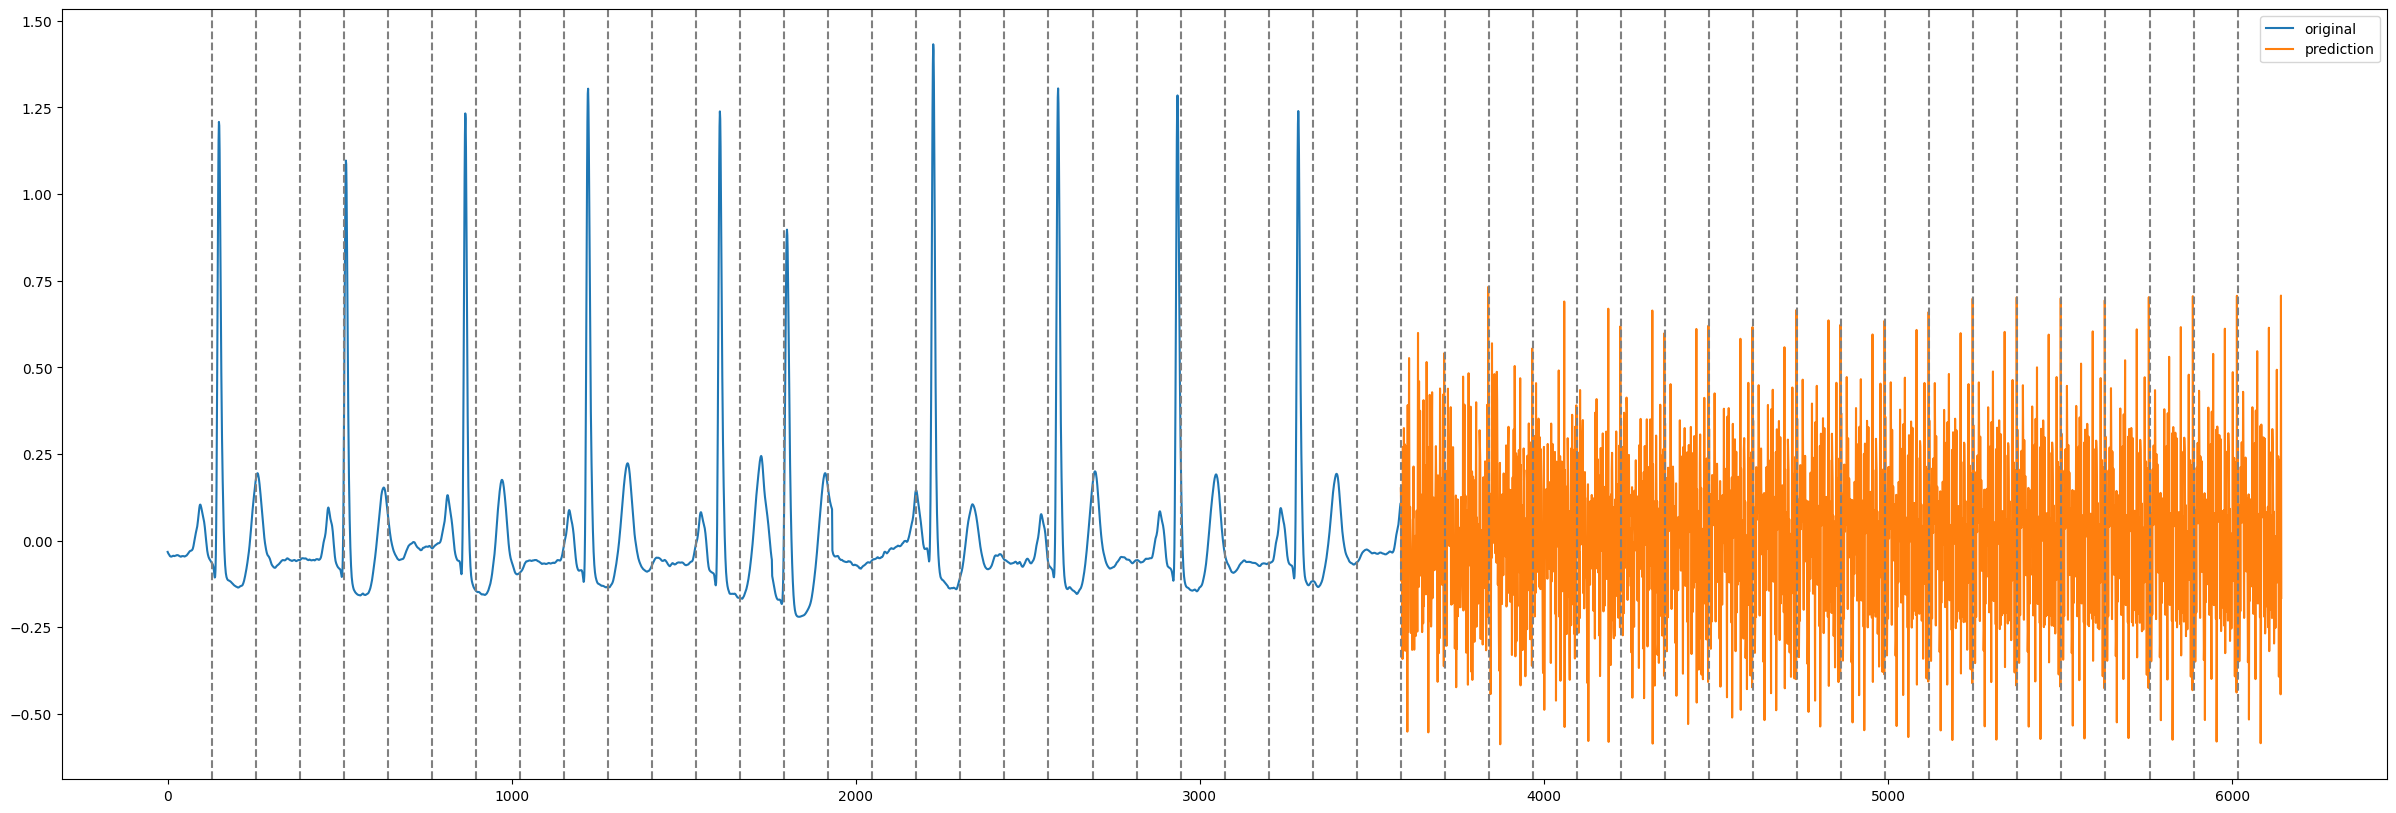

In [8]:
# given the sample predict a new signal

# get the prediction
#sample = sample[:, :600]
print('sample shape', sample.shape)
prediction_tokens = torch.zeros([1, 0]).to('cuda')
for i in range(0, 20):
    if i == 0:
        new_sample = sample
    else:
        flatten_preds = prediction_tokens.view(1, -1)
        # print('flatten_preds shape', flatten_preds.shape)
        # print('sample shape', sample.shape)
        new_sample = torch.cat([sample, flatten_preds.unsqueeze(-1)], dim=1)
        # print('new_sample shape', new_sample.shape)
    # print('new_sample shape', new_sample.shape)
    r1, r2, r3, r4 = xlstm.reconstruct(new_sample, tab_data=tab_data)
    # print('reconstruct shape', reconstruct.shape)
    # the last token is the prediction
    p1 = r1[:, -patch_size:]
    p2 = r2[:, -patch_size:]
    p3 = r3[:, -patch_size:]
    p4 = r4[:, -patch_size:]
    # print('prediction shape', prediction.shape)
    # print('prediction_tokens shape', prediction_tokens.shape)
    # print('prediction shape', prediction.shape)
    # print('prediction_tokens shape', prediction_tokens.shape)
    prediction_tokens = torch.cat([prediction_tokens, p1], dim=1) #, p2, p3, p4], dim=1)

print('prediction_tokens shape', prediction_tokens.shape)
predictions = prediction_tokens.squeeze().view(-1)
print('predictions shape', predictions.shape)

# plot the signal
plt.figure(figsize=(30, 10))
plt.plot(sample[0, :-patch_size].squeeze().cpu().numpy(), label='original')
plt.plot(range(len(sample[0, :-patch_size]), len(sample[0, :-patch_size]) + len(predictions)), predictions.detach().cpu().numpy(), label='prediction')
# add a pipe avery 64 samples
for i in range(1, (len(sample[0]) + len(predictions)) // patch_size -1):
   plt.axvline(x=patch_size*i, color='gray', linestyle='--')
plt.legend()

In [5]:
import dataset.code_15 as code_15
import torch
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt    
from tqdm import tqdm

train_dataset = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360', num_leads=12, random_shift=True, patch_size=64, normalize=False)
train_dataset_cleaned = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360_nkclean', num_leads=12, random_shift=True, patch_size=64, normalize=False)

    


loaded 343287 records
tabular data fields for CODE 15:  Index(['age', 'is_male', '1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF',
       'normal_ecg'],
      dtype='object')
loaded 343287 records
tabular data fields for CODE 15:  Index(['age', 'is_male', '1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF',
       'normal_ecg'],
      dtype='object')


low 1
high 605
middle 342681


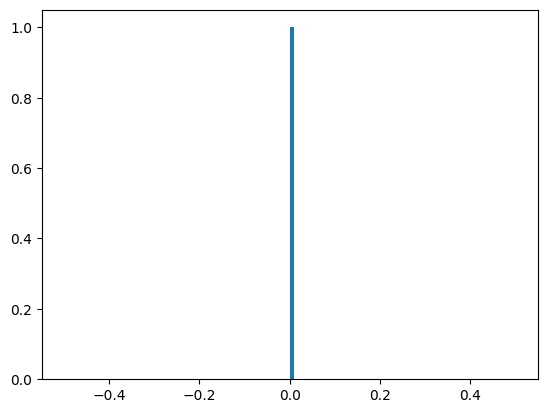

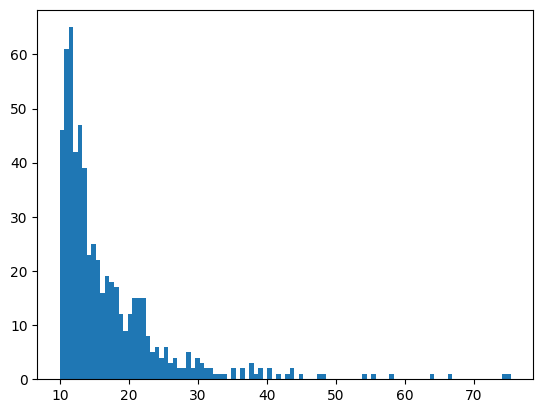

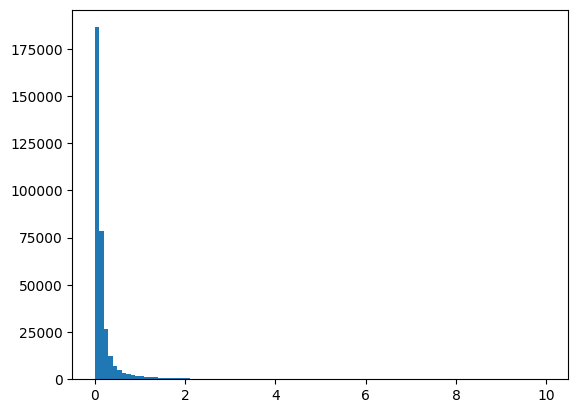

In [5]:
variances = [v[1] for v in vars]
low_variances = [v for v in variances if v < 0.0001]
print('low', len(low_variances))
hihg_variances = [v for v in variances if v > 10 ]
len(hihg_variances)
print('high', len(hihg_variances))
middle_variances = [v for v in variances if v > 0.0001 and v < 10]
len(middle_variances)
print('middle', len(middle_variances))

# plot the histogram of the signal length
plt.hist(low_variances, bins=100)
plt.show()
plt.hist(hihg_variances, bins=100)
plt.show()
plt.hist(middle_variances, bins=100)
plt.show()

number of samples 8
number of samples with high variance 0


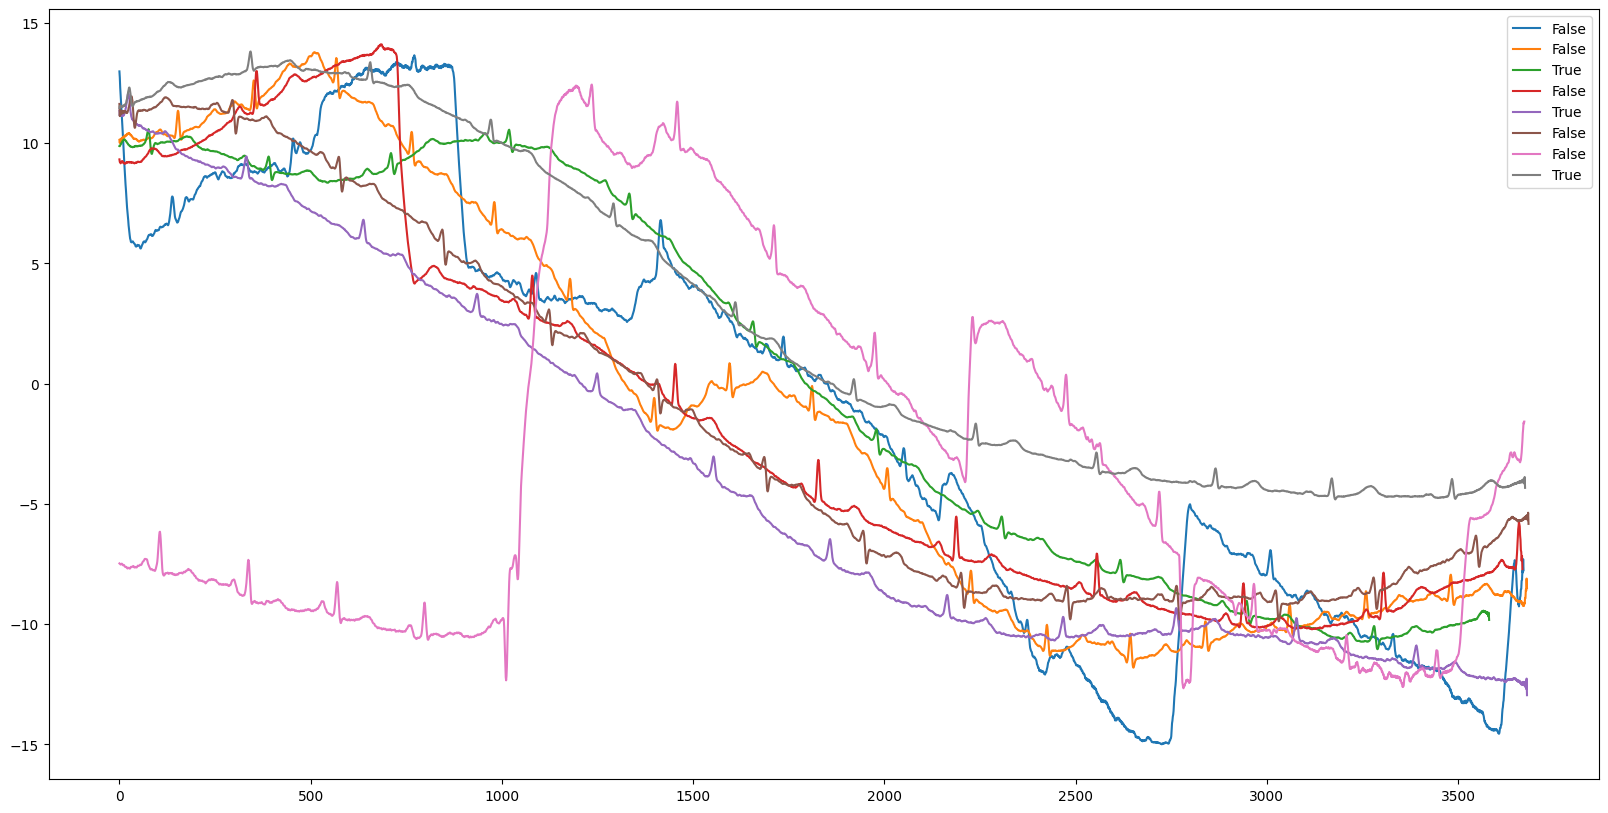

In [10]:
# get the index of the signal with highest variance
max_idx = sorted(vars, key=lambda x: x[1])
# plot the signal with the highest variance

# plot the first 10 samples
count = 0
plt.figure(figsize=(20, 10))
for i in range(1, len(max_idx)):
    sample = train_dataset[max_idx[-i][0]]['signal']
    # sample = (sample - sample.mean()) / sample.std()

    max_val = sample.max().item()
    min_val = sample.min().item()
    tab_data = train_dataset[max_idx[-i][0]]['tab_data']
    # if (max_val > 15 or min_val < -15):
    #print('tab_data', tab_data)
    plt.plot(train_dataset[max_idx[-i][0]]['signal'].squeeze().cpu().numpy(), label=f'{tab_data.loc["normal_ecg"].values[0]}')
    if max_idx[-i][1] < 50:
        break

print('number of samples', i)
print('number of samples with high variance', count)
plt.legend()
plt.show()

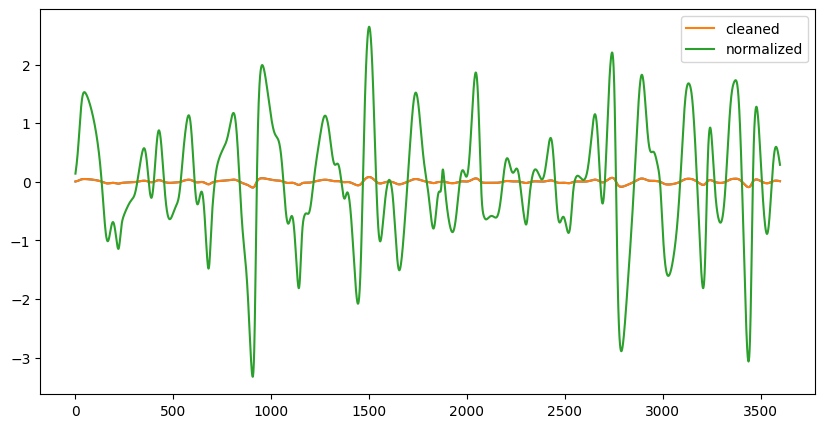

In [ ]:
from torch import nn    

class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean
    

sd = series_decomp(25)


# plot the signal with the highest variance
sample = train_dataset[100]['signal']

plt.figure(figsize=(10, 5))
plt.plot(sample['signal'].squeeze().cpu().numpy())
plt.show()


In [ ]:
batch = next(iter(train_dataloader))

# plot the first sample
x = batch["signal"].to('cuda')
mask = batch["mask"].to('cuda')
tab_data = batch["tab_data"]
# print('initial mask shape', mask.shape)
# print('initial x shape', x.shape)
reconstruct, _, _, _ = xlstm.reconstruct(x, tab_data) 

# get rid of the exeding part on the original signal
shift_x = x[:, :reconstruct.shape[1]]
shift_x = shift_x[:, patch_size:].squeeze()

mask_shifted = mask[:, :reconstruct.shape[1]]
mask_shifted = mask_shifted[:, patch_size:].squeeze()

mask_idxs, lol = torch.where(mask_shifted == 0)
print('lol', lol.shape)

shift_reconstruct = reconstruct[:, :-patch_size]

#print('mask shape', mask.shape)
#print('x shape', x.shape)   
#print('reconstruct shape', shift_reconstruct.shape)

# shift_reconstruct = shift_reconstruct.masked_fill(mask_shifted, 0)
# shift_x = shift_x.masked_fill(mask_shifted, 0)

print('mask_shifted shape', mask_shifted.shape)
print('shift_x shape', shift_x.shape)
print('max_idxs has shape', mask_idxs.shape)
print('max_idxs 0 is ', mask_idxs[0])
print('shift_reconstruct shape', shift_reconstruct.shape)
# add a pipe avery 64 samples

# m = shift_x == mask_idxs
# plot the first sample
plt.figure(figsize=(10, 5))
plt.plot(shift_x[0].squeeze().cpu().numpy(), label='original')
plt.plot(shift_reconstruct[0].squeeze().detach().cpu().numpy(), label='reconstructed')
ma_inp = shift_x[0] * mask_shifted[0]
print('ma_inp shape', ma_inp.shape)
plt.plot(ma_inp.cpu().numpy(), label='lol')
#plot mask
# plt.plot(mask_shifted[0].cpu().numpy(), label='mask')
plt.legend()

In [6]:
from matplotlib import pyplot as plt    
import dataset.code_15 as code_15

train_dataset = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records_360_nkclean', num_leads=12, random_shift=False, patch_size=64, normalize=True)
train_original = code_15.ECGCODE15Dataset('/media/Volume/data/CODE15/unlabeled_records', num_leads=12, random_shift=False, patch_size=64, normalize=False)

train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=code_15.collate_fn)

# plot the first sample


loaded 343287 records
tabular data fields for CODE 15:  Index(['age', 'is_male', '1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF',
       'normal_ecg'],
      dtype='object')
loaded 345109 records
tabular data fields for CODE 15:  Index(['age', 'is_male', '1dAVb', 'RBBB', 'LBBB', 'SB', 'ST', 'AF',
       'normal_ecg'],
      dtype='object')


torch.Size([4096])


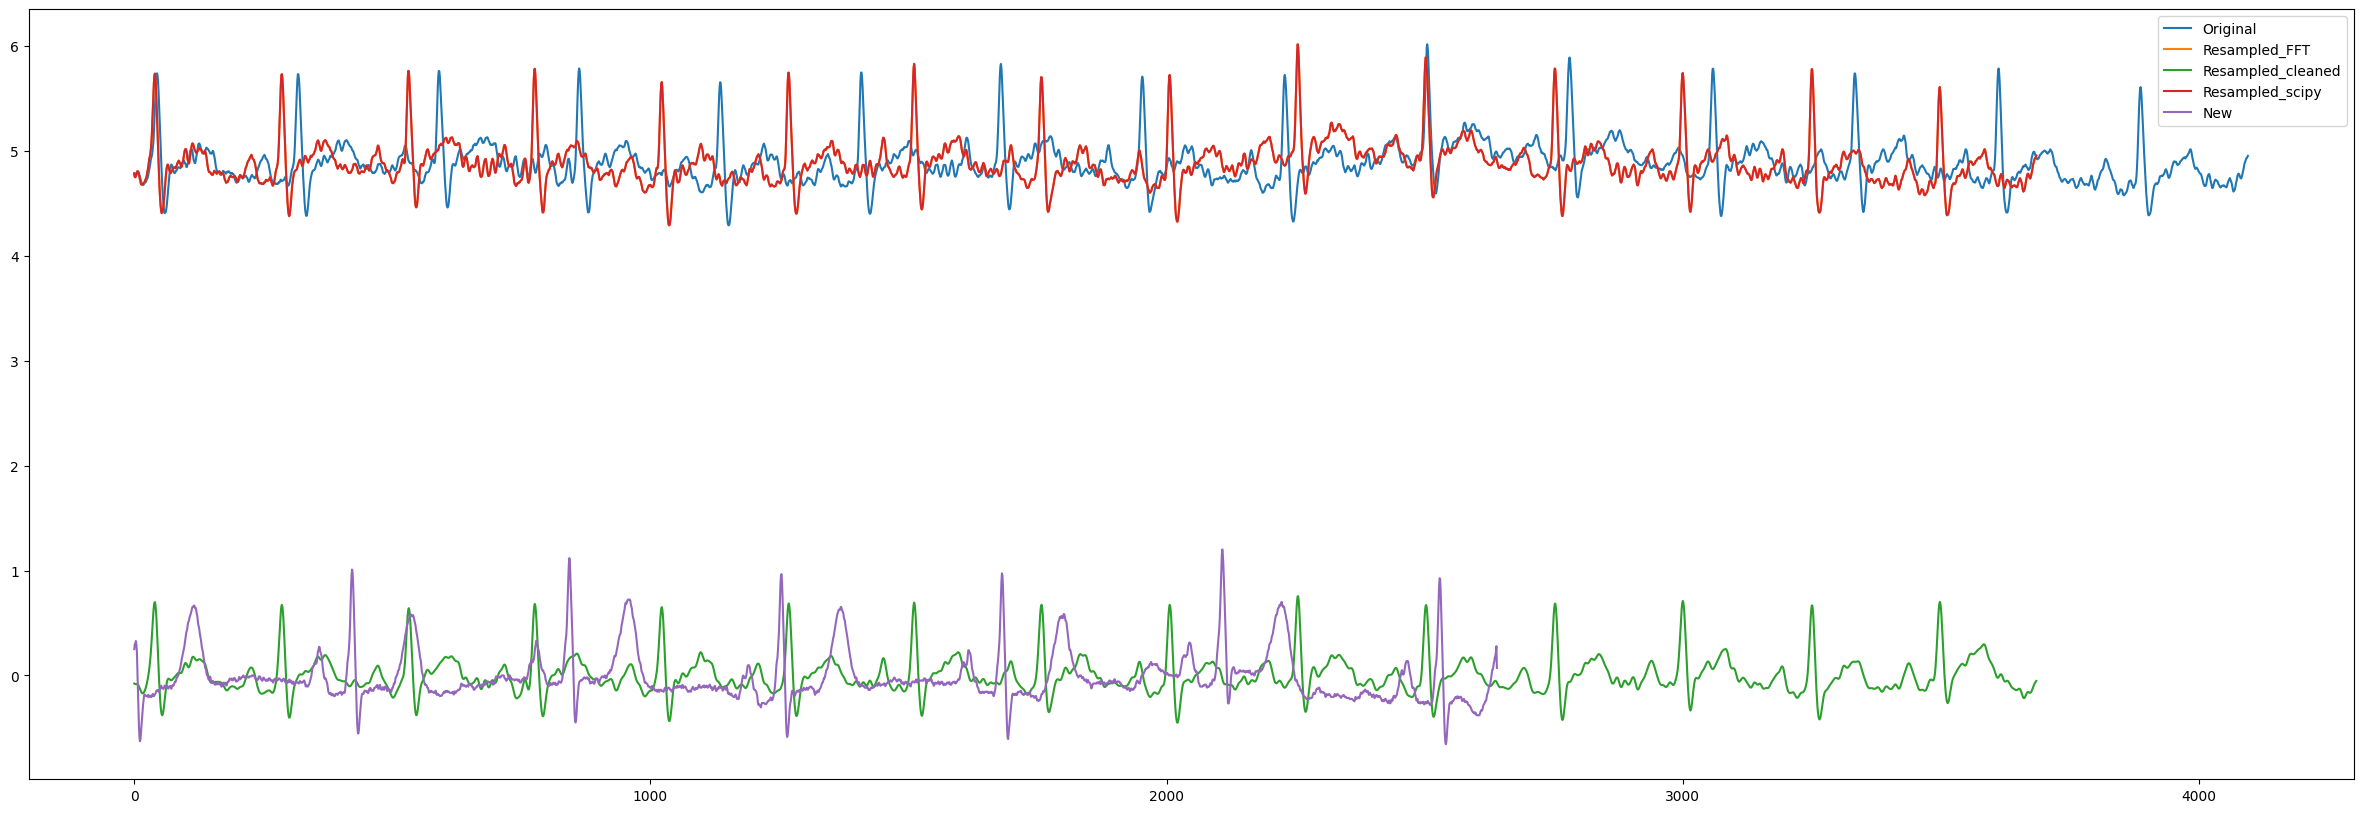

In [84]:
idx = 9878
sample_orig = train_original[idx]['signal'][:, 1]
sample_new = train_dataset[idx]['signal']
print(sample_orig.shape)
plt.figure(figsize=(30, 10))
plt.plot(sample_orig, label='Original')


resampled = nk.signal_resample(sample_orig, sampling_rate=400, desired_sampling_rate=360, method='FFT')
plt.plot(resampled, label='Resampled_FFT')
resampled = nk.signal_resample(sample_orig, sampling_rate=400, desired_sampling_rate=360, method='FFT')
resampled = nk.ecg_clean(resampled, sampling_rate=360, method='nk')
plt.plot(resampled, label='Resampled_cleaned')
#scipy resample
from scipy.signal import resample
resampled = resample(sample_orig, len(sample_orig) * 360 // 400)
plt.plot(resampled, label='Resampled_scipy')

plt.plot(sample_new, label='New')   

plt.legend()


torch.Size([3686])
torch.Size([10, 3686])
torch.Size([10, 3686])


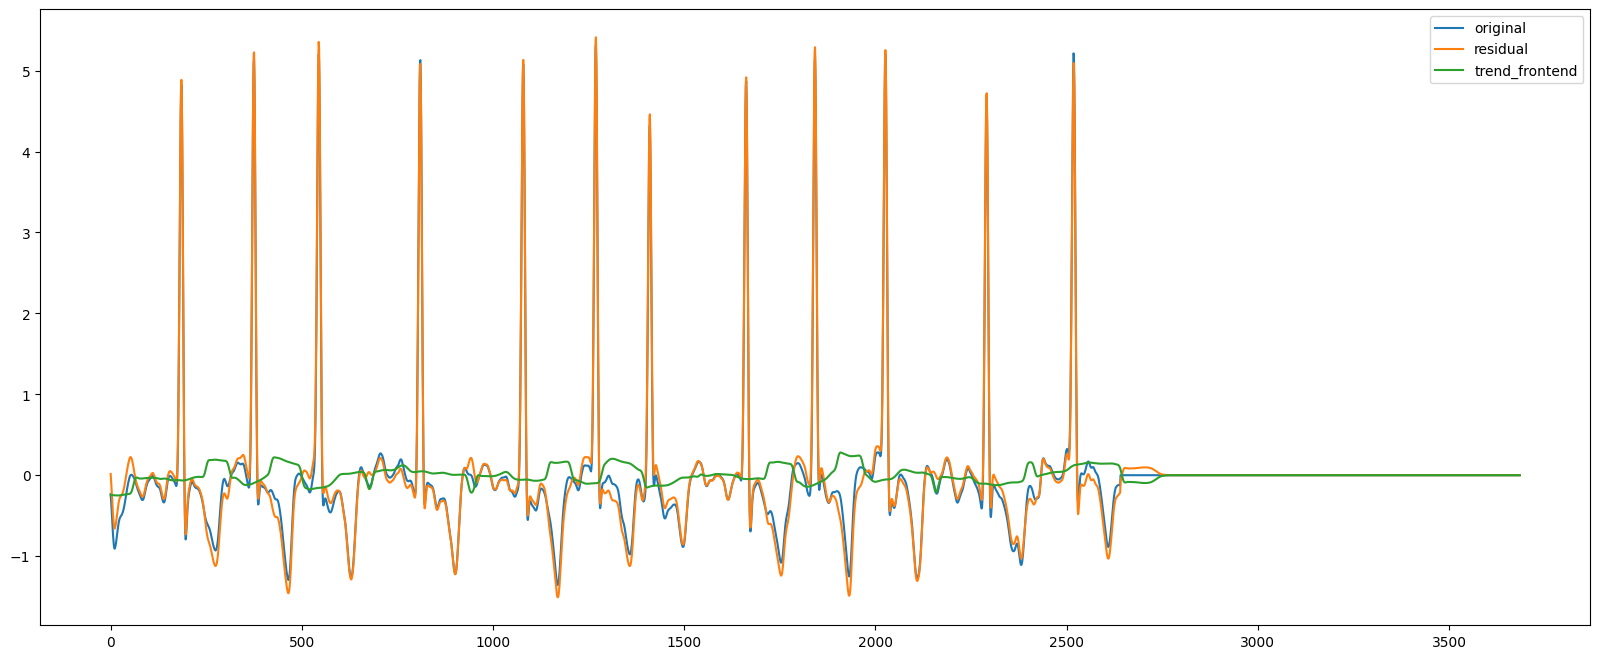

In [20]:
from torch import nn
class MovingAvg(nn.Module):
    def __init__(self, moving_avg, front_end):
        super(MovingAvg, self).__init__()
        self.kernel_size = moving_avg
        self.avg = nn.AvgPool1d(kernel_size=moving_avg, stride=1, padding=0)
        self.front_end = front_end

    def forward(self, x):
        # padding on the both ends of time series
        if not self.front_end:
            front = x[:, 0:1, :].repeat(1, self.kernel_size-1, 1)
            x = torch.cat([front, x], dim=1)

        else:
            front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
            end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
            x = torch.cat([front, x, end], dim=1)

        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x        
    

class SeriesDecomposition(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size, front_end):
        super(SeriesDecomposition, self).__init__()
        self.moving_avg = MovingAvg(kernel_size, front_end)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean
    
sd = SeriesDecomposition(251, front_end=True)
    
sample = next(iter(train_dataloader))

decomposed = sd(sample['signal'])

#fft = torch.fft(sample['signal'], dim=1)

print(sample['signal'][0].squeeze().shape)
print(decomposed[0].squeeze().shape)
print(decomposed[1].squeeze().shape)

# plot the first sample
plt.figure(figsize=(20, 8))
plt.plot(sample['signal'][0].squeeze().cpu().numpy(), label='original')
plt.plot(decomposed[0][0].squeeze().cpu().numpy(), label='residual')
plt.plot(decomposed[1][0].squeeze().cpu().numpy(), label='trend_frontend')
# plt.plot(sd_f(sample['signal'])[0][0].squeeze().cpu().numpy(), label='trend_actual')
plt.legend()
plt.show()





/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(
/home/luna97/Research/MIT-BIH_ecg_arrhytmia/mit_bih_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your u

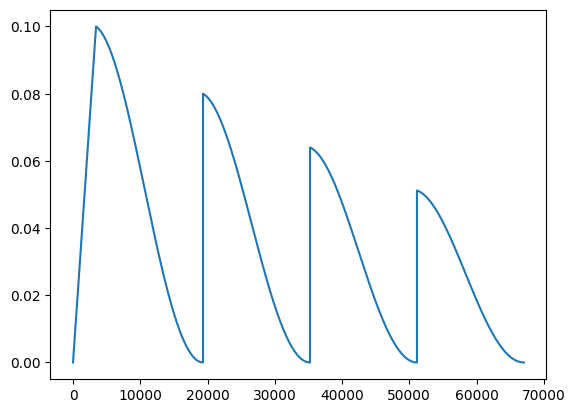

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math
import torch
import torch.optim as optim
from matplotlib import pyplot as plt


def get_cosine_with_hard_restarts_schedule_with_warmup_and_decay(
    optimizer, 
    num_warmup_steps, 
    num_training_steps, 
    num_cycles=1, 
    decay_factor=0.9
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return current_step / max(1, num_warmup_steps)
        
        progress = (current_step - num_warmup_steps) / max(1, num_training_steps - num_warmup_steps)
        cycle_progress = progress * num_cycles % 1  # Progress within the current cycle
        decay = decay_factor ** (progress * num_cycles)  # Apply decay per cycle

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * cycle_progress))) * decay
    
    return LambdaLR(optimizer, lr_lambda)

model = torch.nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)
steps_per_epoch = 2682
epochs = 25
train_steps = steps_per_epoch * epochs
warmup_steps = steps_per_epoch  * 2

lr_scheduler = get_cosine_with_hard_restarts_schedule_with_warmup_and_decay(
    optimizer, 
    num_warmup_steps=warmup_steps, 
    num_training_steps=train_steps, 
    num_cycles=(train_steps // warmup_steps) // 4, decay_factor=0.8)

lrs = []
for epoch in range(train_steps):
    # train step goes here
    lr_scheduler.step(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])

plt.plot(lrs)

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math

def get_cosine_with_hard_restarts_schedule_with_warmup_and_decay(
    optimizer, 
    num_warmup_steps, 
    num_training_steps, 
    num_cycles=1, 
    decay_factor=0.9
):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return current_step / max(1, num_warmup_steps)
        
        progress = (current_step - num_warmup_steps) / max(1, num_training_steps - num_warmup_steps)
        cycle_progress = progress * num_cycles % 1  # Progress within the current cycle
        decay = decay_factor ** (progress * num_cycles)  # Apply decay per cycle

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * cycle_progress))) * decay
    
    return LambdaLR(optimizer, lr_lambda)
    break

   age  is_male
0   64     True
0   83     True
0   84    False
0    0     True
0   84    False
0    0     True
0   61     True
0   83    False
0   89     True
0   76    False
0   89     True
0   84    False
0   84    False
0   83    False
0   32    False
0   69     True
0    0     True
0    0     True
0   24    False
0   80    False
0   89     True
0   83     True
0   73    False
0   84    False
0   89     True
0   57     True
0   89     True
0   63    False
0   80    False
0   61     True
0   83     True
0   57     True
